<a href="https://colab.research.google.com/github/Phosteve/Machine_Learning_practice/blob/master/Our_power_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Import Required Libraries**

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


**Step 2: Prepare Data**

In [19]:
# Load the data
df = pd.read_csv('mmu-power-consumption1.csv')

In [20]:
df

,Month,number_of_students,main_meter_reading
0,Jan-18,5470,90845
1,Feb-18,5470,92393
2,Mar-18,5470,94344
3,Apr-18,5470,93167
4,May-18,2947,81204
...,...,...,...
69,Oct-23,7702,109879
70,Nov-23,7702,105360
71,Dec-23,7702,105360
72,Jan-24,7951,94756


In [21]:
# Check for missing values
print(df.isnull().sum())

Month                 0
number_of_students    0
main_meter_reading    0
dtype: int64


In [22]:
# Convert Month to numerical format
df['Month'] = pd.to_datetime(df['Month'], format='%b-%y')

# Extract year and month information
df['Year'] = df['Month'].dt.year
df['Month'] = df['Month'].dt.month

In [26]:
df

,Month,number_of_students,main_meter_reading,Year
0,1,5470,90845,2018
1,2,5470,92393,2018
2,3,5470,94344,2018
3,4,5470,93167,2018
4,5,2947,81204,2018
...,...,...,...,...
69,10,7702,109879,2023
70,11,7702,105360,2023
71,12,7702,105360,2023
72,1,7951,94756,2024


In [23]:
df.describe()

,Month,number_of_students,main_meter_reading,Year
count,74.000000,74.000000,74.000000,74.000000
mean,6.364865,5773.324324,96217.472973,2020.594595
std,3.525152,1586.845152,8565.036185,1.789765
min,1.000000,2947.000000,78614.000000,2018.000000
25%,3.000000,3951.000000,90969.250000,2019.000000
50%,6.000000,6533.000000,96986.000000,2021.000000
75%,9.000000,6853.000000,102180.750000,2022.000000
max,12.000000,7951.000000,122199.000000,2024.000000


In [24]:
df

,Month,number_of_students,main_meter_reading,Year
0,1,5470,90845,2018
1,2,5470,92393,2018
2,3,5470,94344,2018
3,4,5470,93167,2018
4,5,2947,81204,2018
...,...,...,...,...
69,10,7702,109879,2023
70,11,7702,105360,2023
71,12,7702,105360,2023
72,1,7951,94756,2024


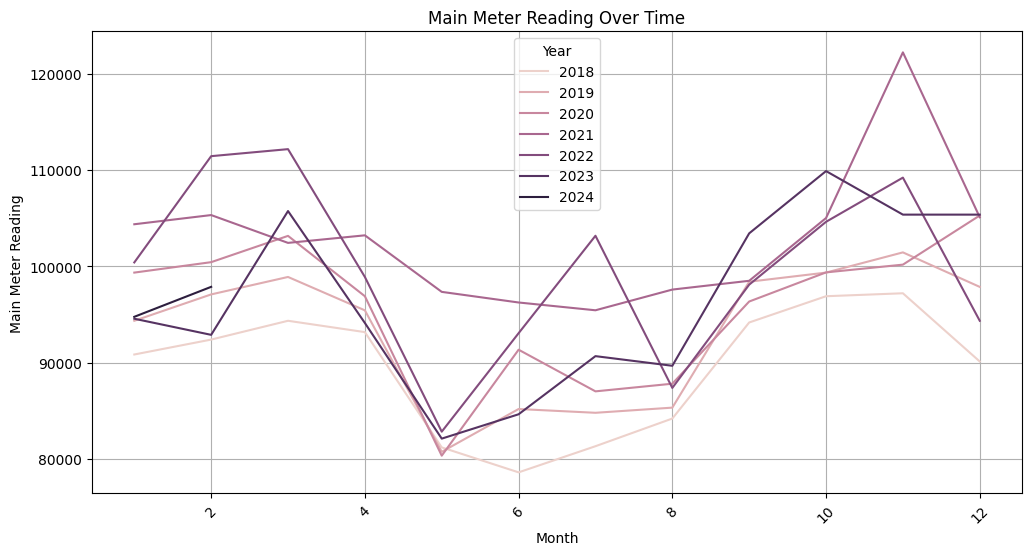

In [10]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='main_meter_reading', hue='Year', data=df)
plt.title('Main Meter Reading Over Time')
plt.xlabel('Month')
plt.ylabel('Main Meter Reading')
plt.xticks(rotation=45)
plt.legend(title='Year')
plt.grid(True)
plt.show()


1. This plot shows how the main meter reading changes over time, specifically across different months and years.
2. Each line represents a different year, allowing you to observe trends and patterns in main meter readings over the months within each year.
3. By visualizing the data in this way, you can identify any seasonal or long-term trends in power consumption.


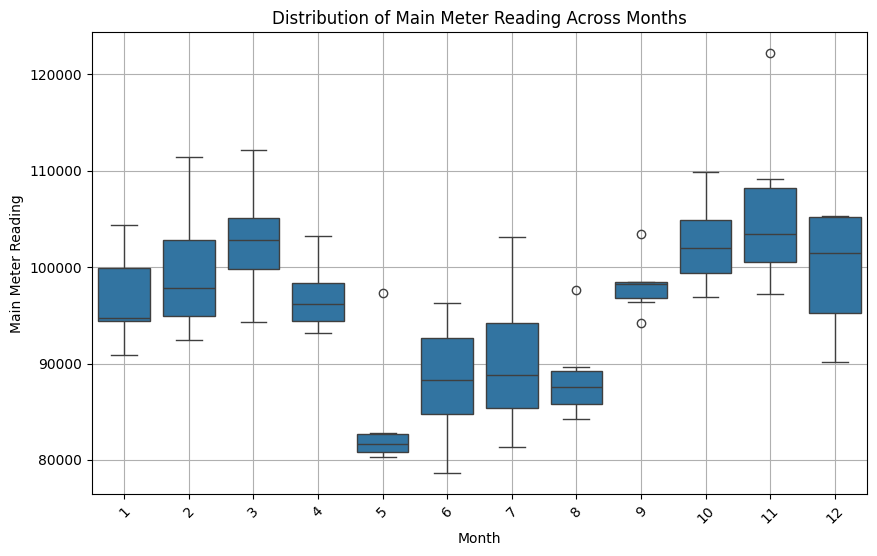

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='main_meter_reading', data=df)
plt.title('Distribution of Main Meter Reading Across Months')
plt.xlabel('Month')
plt.ylabel('Main Meter Reading')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


1. This boxplot displays the distribution of main meter readings across different months.
2. It allows you to compare the central tendency (median) and variability (interquartile range) of main meter readings for each month.
3. You can identify if there are any significant differences in power consumption between months or if there are outliers in certain months.

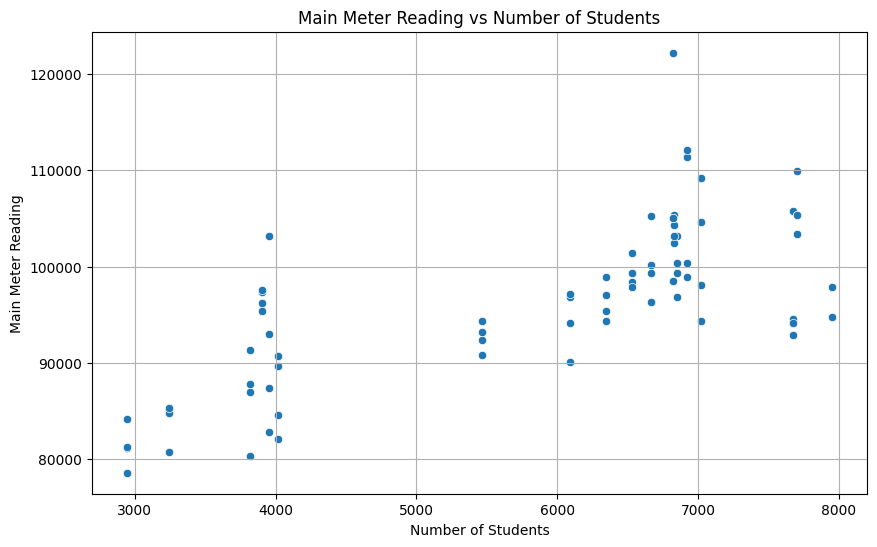

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='number_of_students', y='main_meter_reading', data=df)
plt.title('Main Meter Reading vs Number of Students')
plt.xlabel('Number of Students')
plt.ylabel('Main Meter Reading')
plt.grid(True)
plt.show()


1. This scatter plot illustrates the relationship between the main meter reading and the number of students.
2. Each point represents a specific observation, with the x-coordinate indicating the number of students and the y-coordinate indicating the main meter reading.
3. By examining the scatter plot, you can discern if there's any correlation or pattern between power consumption and the number of students.

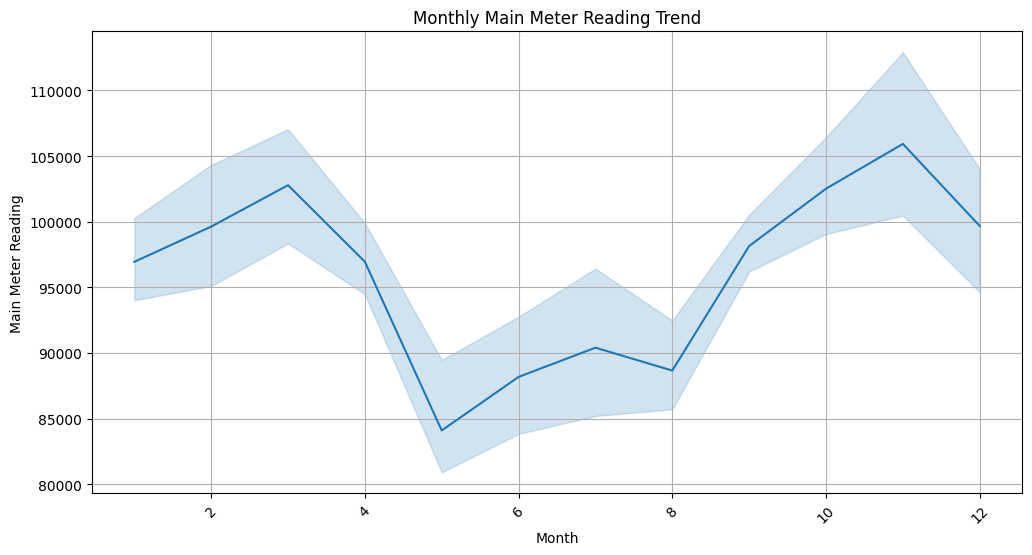

In [13]:
# Visualize main_meter_reading over time (Month-Year)
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='main_meter_reading', data=df)
plt.title('Monthly Main Meter Reading Trend')
plt.xlabel('Month')
plt.ylabel('Main Meter Reading')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

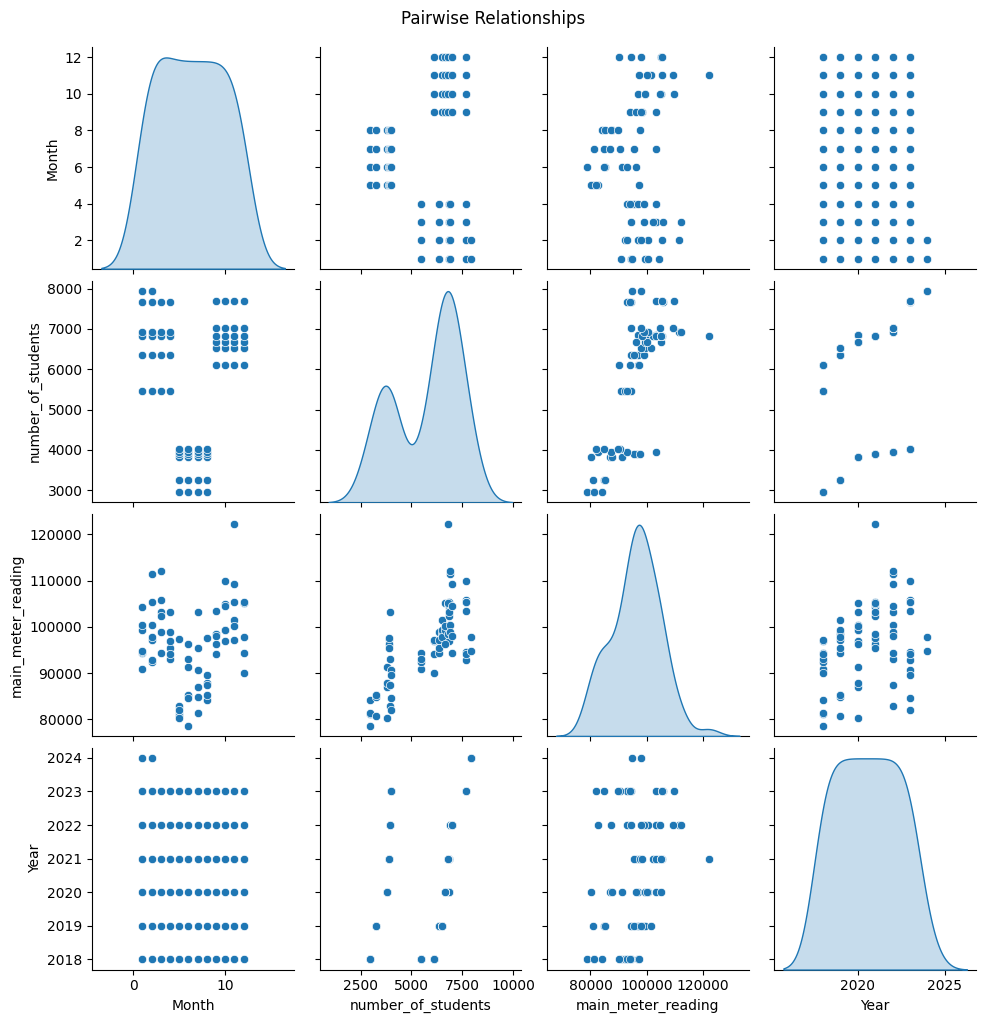

In [14]:
sns.pairplot(df[['Month', 'number_of_students', 'main_meter_reading', 'Year']], diag_kind='kde')
plt.suptitle('Pairwise Relationships', y=1.02)
plt.show()

1. This pairplot displays pairwise relationships between the variables: Month, number_of_students, main_meter_reading, and Year.
2. Along the diagonal, kernel density estimation (KDE) plots show the distribution of each variable.
3. The scatterplots in the lower triangle show the relationship between pairs of variables, while the upper triangle shows the correlation coefficient between them.
4. It helps to identify potential correlations between variables and any nonlinear relationships between them.

In [9]:
# Select relevant features including the new numeric representation
data = df[['number_of_students', 'main_meter_reading']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define sequence length
sequence_length = 12  # Example: consider data from the past 12 months to predict the next month

# Generate sequences
sequences = []
targets = []
for i in range(len(scaled_data) - sequence_length):
    sequences.append(scaled_data[i:i + sequence_length])
    targets.append(scaled_data[i + sequence_length])

# Convert sequences and targets to numpy arrays
X = np.array(sequences)
y = np.array(targets)

# Train-test split
split = int(0.8 * len(X))  # 80% training, 20% testing
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape data for LSTM input (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], data.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], data.shape[1])


**Step 3: Define and Compile LSTM Model**

In [48]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))  # Predicting the main meter reading
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               41200     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 41301 (161.33 KB)
Trainable params: 41301 (161.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Step 4: Fit the Model**

In [52]:
history = model.fit(X_train, y_train[:, 1], epochs=50, batch_size=32, validation_data=(X_test, y_test[:, 1]), verbose=2, shuffle=False)


Epoch 1/50
2/2 - 0s - loss: 0.0560 - val_loss: 0.0816 - 176ms/epoch - 88ms/step
Epoch 2/50
2/2 - 0s - loss: 0.0516 - val_loss: 0.0598 - 129ms/epoch - 64ms/step
Epoch 3/50
2/2 - 0s - loss: 0.0356 - val_loss: 0.0493 - 103ms/epoch - 52ms/step
Epoch 4/50
2/2 - 0s - loss: 0.0406 - val_loss: 0.0458 - 90ms/epoch - 45ms/step
Epoch 5/50
2/2 - 0s - loss: 0.0426 - val_loss: 0.0452 - 73ms/epoch - 37ms/step
Epoch 6/50
2/2 - 0s - loss: 0.0427 - val_loss: 0.0450 - 89ms/epoch - 45ms/step
Epoch 7/50
2/2 - 0s - loss: 0.0404 - val_loss: 0.0449 - 90ms/epoch - 45ms/step
Epoch 8/50
2/2 - 0s - loss: 0.0411 - val_loss: 0.0455 - 88ms/epoch - 44ms/step
Epoch 9/50
2/2 - 0s - loss: 0.0338 - val_loss: 0.0475 - 49ms/epoch - 24ms/step
Epoch 10/50
2/2 - 0s - loss: 0.0346 - val_loss: 0.0510 - 49ms/epoch - 24ms/step
Epoch 11/50
2/2 - 0s - loss: 0.0380 - val_loss: 0.0549 - 47ms/epoch - 23ms/step
Epoch 12/50
2/2 - 0s - loss: 0.0371 - val_loss: 0.0570 - 47ms/epoch - 23ms/step
Epoch 13/50
2/2 - 0s - loss: 0.0378 - val_loss

**Step 5: Evaluate the Model**

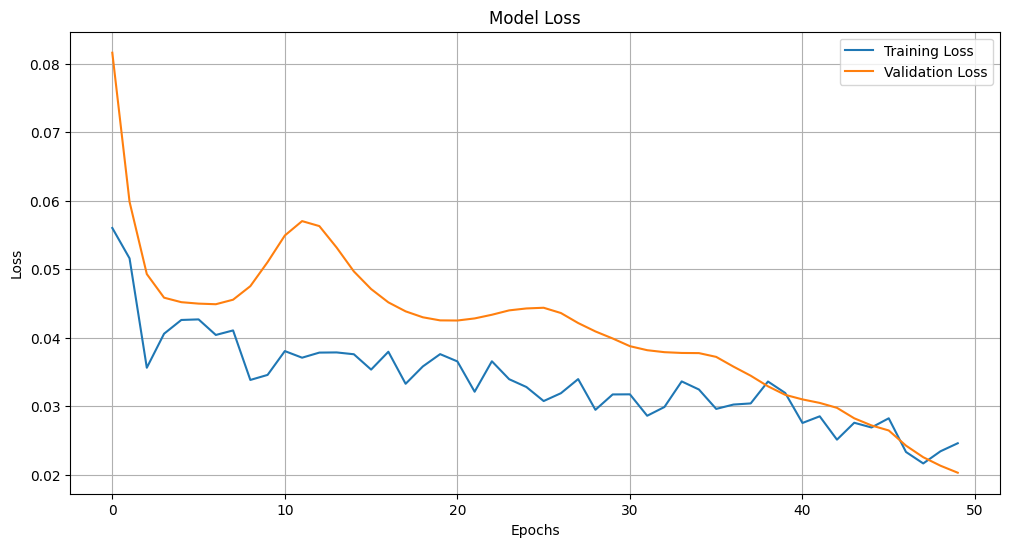

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [54]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
inv_train_predict = scaler.inverse_transform(np.concatenate((X_train[:, -1, :-1], train_predict), axis=1))
inv_test_predict = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], test_predict), axis=1))

# Extract the main meter reading predictions
inv_train_predict = inv_train_predict[:, -1]
inv_test_predict = inv_test_predict[:, -1]


1/1 [==============================] - 0s 21ms/step


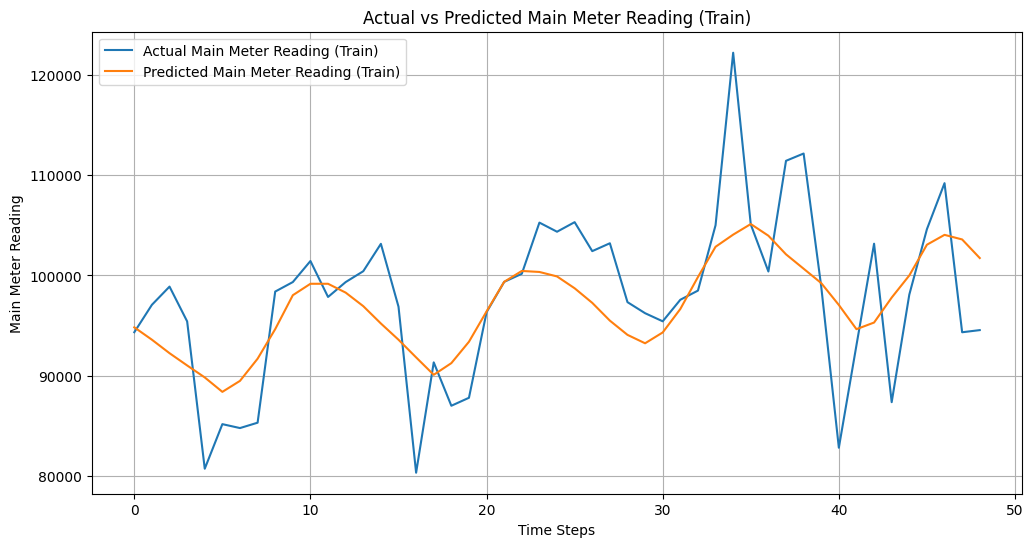

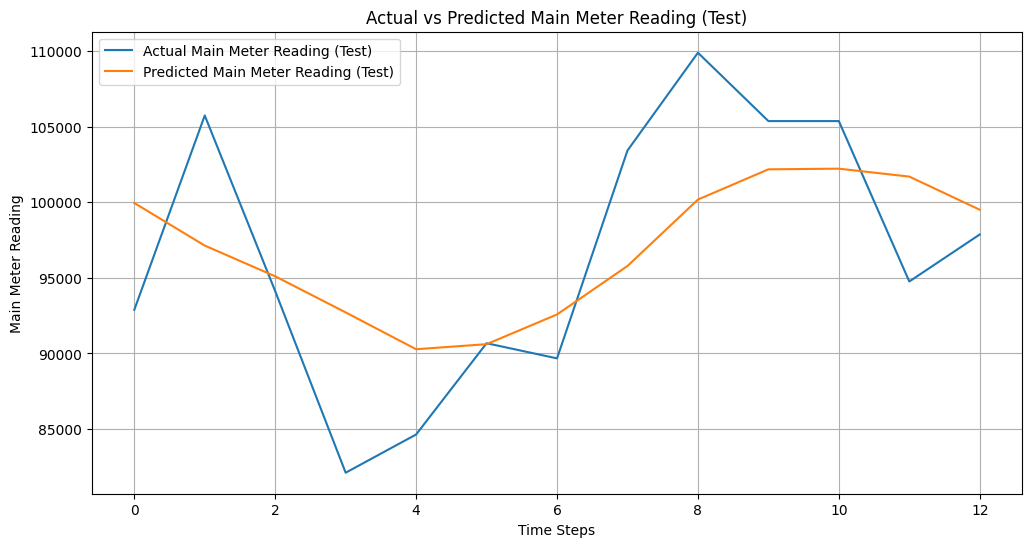

In [57]:
# Plot actual vs predicted values for training data
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(y_train)[:, 1], label='Actual Main Meter Reading (Train)')
plt.plot(inv_train_predict, label='Predicted Main Meter Reading (Train)')
plt.title('Actual vs Predicted Main Meter Reading (Train)')
plt.xlabel('Time Steps')
plt.ylabel('Main Meter Reading')
plt.legend()
plt.grid(True)
plt.show()

# Plot actual vs predicted values for testing data
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(y_test)[:, 1], label='Actual Main Meter Reading (Test)')
plt.plot(inv_test_predict, label='Predicted Main Meter Reading (Test)')
plt.title('Actual vs Predicted Main Meter Reading (Test)')
plt.xlabel('Time Steps')
plt.ylabel('Main Meter Reading')
plt.legend()
plt.grid(True)
plt.show()


**Step 6: Evaluate Model Performance**

In [62]:
from sklearn.metrics import mean_squared_error

# Calculate the range of the target variable for training and testing data
train_range = np.max(scaler.inverse_transform(y_train)[:, 1]) - np.min(scaler.inverse_transform(y_train)[:, 1])
test_range = np.max(scaler.inverse_transform(y_test)[:, 1]) - np.min(scaler.inverse_transform(y_test)[:, 1])

# Calculate RMSE for training and testing data
train_rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_train)[:, 1], inv_train_predict))
test_rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test)[:, 1], inv_test_predict))

# Calculate percentage RMSE for training and testing data
train_rmse_percentage = (train_rmse / train_range) * 100
test_rmse_percentage = (test_rmse / test_range) * 100

# Print percentage RMSE for training and testing data
print(f'Train RMSE (%): {train_rmse_percentage}')
print(f'Test RMSE (%): {test_rmse_percentage}')


Train RMSE (%): 14.60449577133096
Test RMSE (%): 22.351873045313624


In [67]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(scaler.inverse_transform(y_train)[:, 1], inv_train_predict)
test_mape = mean_absolute_percentage_error(scaler.inverse_transform(y_test)[:, 1], inv_test_predict)

print(f'Train MAPE: {train_mape}%')
print(f'Test MAPE: {test_mape}%')


Train MAPE: 4.818371419175342%
Test MAPE: 5.451489577930261%


In [68]:
from sklearn.metrics import mean_absolute_error

train_mae = mean_absolute_error(scaler.inverse_transform(y_train)[:, 1], inv_train_predict)
test_mae = mean_absolute_error(scaler.inverse_transform(y_test)[:, 1], inv_test_predict)

print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')


Train MAE: 4660.2215780445495
Test MAE: 5237.6623471906605


In [60]:
# For making future predictions, you can create a new sequence based on the last available data
# Example: Predict the next month's main meter reading based on the last 12 months' data

last_sequence = scaled_data[-sequence_length:]
future_prediction = model.predict(last_sequence.reshape(1, sequence_length, data.shape[1]))
future_prediction = scaler.inverse_transform(np.concatenate((last_sequence[-1, :-1].reshape(1, -1), future_prediction), axis=1))
future_main_meter_reading = future_prediction[0, -1]

print(f'Predicted Main Meter Reading for next month: {future_main_meter_reading}')


1/1 [==============================] - 0s 71ms/step
Predicted Main Meter Reading for next month: 97205.61043778063
